In [6]:
import gymnasium as gym
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import rl_utils

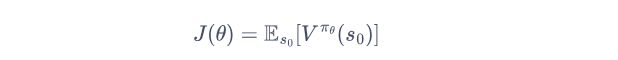  
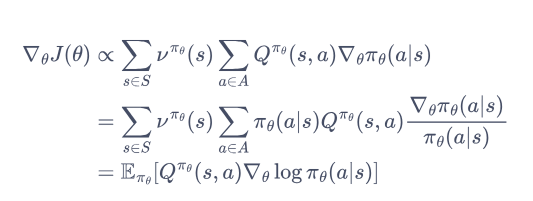  
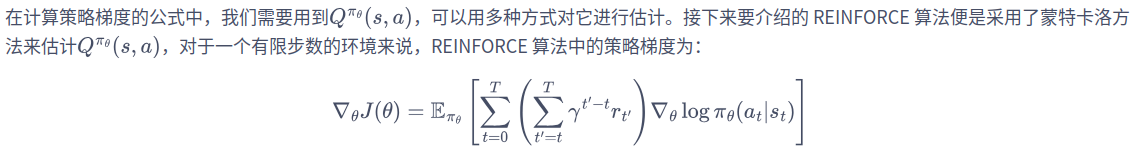

首先定义策略网络PolicyNet，其输入是某个状态，输出则是该状态下的动作概率分布，这里采用在离散动作空间上的softmax()函数来实现一个可学习的多项分布（multinomial distribution）

In [7]:
class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return F.softmax(self.fc2(x), dim=1)
        # 输出形状为(batch_size,action_dim)

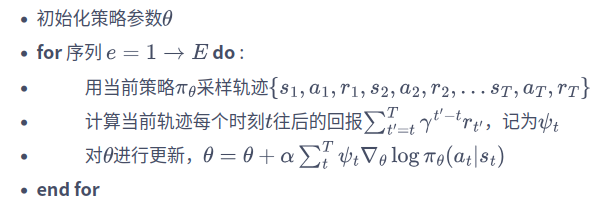

在函数take_action()函数中，我们通过动作概率分布对离散的动作进行采样。  
在更新过程中，我们按照算法将损失函数写为策略回报的负数，即
$$loss=-\sum\limits^{T}_{t}Q^{\pi_{\theta}}(s,a)*log(\pi_{\theta}(a_t|s_t))$$
即优化原来的目标函数等于优化loss:
$$\underset {\theta}{max}J(\theta)=\underset {\theta}{max}E_{S_0}[V^{\pi_{\theta}}(s_0)]
\\=\underset {\theta}{min}loss=\underset {\theta}{min}\{-\sum\limits^{T}_{t}Q^{\pi_{\theta}}(s,a)*log(\pi_{\theta}(a_t|s_t))\}$$
对$\theta$求导后就可以通过梯度下降来更新策略。
$$\frac{\partial loss}{\partial \theta}=-\sum\limits^{T}_{t}Q^{\pi_{\theta}}(s,a)*\nabla_{\theta}log(\pi_{\theta}(a_t|s_t))$$
$$\nabla_{\theta}J(\theta)=E_{(S \sim \eta,A \sim \pi(A|S,\theta))}[Q^{\pi_{\theta}}(S,A)*\nabla_{\theta}log(\pi_{\theta}(A|S))]$$

In [ ]:
class REINFORCE:
    def __init__(self, state_dim, hidden_dim, action_dim, learning_rate, gamma, device):

        self.policy_net = PolicyNet(state_dim, hidden_dim,action_dim).to(device)

        self.optimizer = torch.optim.Adam(self.policy_net.parameters(),lr=learning_rate)  # 使用Adam优化器
        
        self.gamma = gamma  # 折扣因子
        self.device = device

    def take_action(self, state):  # 根据动作概率分布随机采样
        # state = torch.tensor([state], dtype=torch.float).to(self.device)
        state = torch.tensor(state, dtype=torch.float).unsqueeze(0).to(self.device)

        # (1,state_dim)
        probs = self.policy_net(state)
        # 输出每个动作的概率(1,action_dim)
        action_dist = torch.distributions.Categorical(probs)
        action = action_dist.sample()
        # 组合使用,创建Categorical对象,使用sample方法采样
        return action.item()

    def update(self, transition_dict):
        # 传入一个episode的数据(s0,a0,r0)
        reward_list = transition_dict['rewards']
        state_list = transition_dict['states']
        action_list = transition_dict['actions']

        G = 0
        self.optimizer.zero_grad()
        for i in reversed(range(len(reward_list))):  # 从最后一步算起
            reward = reward_list[i]
            # (1,state_dim)
            state = torch.tensor([state_list[i]],dtype=torch.float).to(self.device)
            # (1,1)
            action = torch.tensor([action_list[i]]).view(-1, 1).to(self.device)
            # (1,1)
            log_prob = torch.log(self.policy_net(state).gather(1, action))
            # log_prob由T->0每一步都需要进行重新计算
            G = self.gamma * G + reward
            # G就是q_value是从尾向前反向计算的
            loss = -log_prob * G  # 每一步的损失函数
            
            loss.backward()  # 反向传播计算梯度
            # 梯度进行了累计,为了保证一个episode都是同一个policy产生的
        self.optimizer.step()  # 梯度下降

$$loss=-\sum\limits^{T}_{t}Q^{\pi_{\theta_t}}_t(s_t,a_t)*log(\pi_{\theta}(a_t|s_t,\theta_t))$$
$$\frac{\partial loss}{\partial \theta}=-\sum\limits^{T}_{t}Q^{\pi_{\theta_t}}_t(s_t,a_t)*\nabla_{\theta}log(\pi_{\theta}(a_t|s_t,\theta_t))$$

<pre>稳定性

    整个episode的梯度方向更稳定

    减少了参数更新的方差

    避免了" zig-zag"现象（来回震荡）

理论一致性

    REINFORCE是蒙特卡洛方法，应该使用完整的轨迹

    每个动作的梯度都使用相同的策略参数计算

    如果中间更新参数，后续梯度计算基于的是"新策略"，破坏了理论假设

In [9]:
learning_rate = 1e-3
num_episodes = 1000
hidden_dim = 128
gamma = 0.98
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

env_name = "CartPole-v1"
env = gym.make(env_name)
env.reset(seed=0)
torch.manual_seed(0)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
agent = REINFORCE(state_dim, hidden_dim, action_dim, learning_rate, gamma,device)

return_list = []
for i in range(10):
    with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
        for i_episode in range(int(num_episodes / 10)):
            episode_return = 0
            transition_dict = {
                'states': [],
                'actions': [],
                'next_states': [],
                'rewards': [],
                'dones': []
            }
            state = env.reset()[0]
            done = False

            while not done:
                action = agent.take_action(state)
                next_state, reward, done, truncated ,_= env.step(action)
                # 有些环境没有done，时间到了truncated为true
                done = done or truncated
                transition_dict['states'].append(state)
                transition_dict['actions'].append(action)
                transition_dict['rewards'].append(reward)
                transition_dict['next_states'].append(next_state)
                transition_dict['dones'].append(done)
                state = next_state
                episode_return += reward
            return_list.append(episode_return)

            # 只进行一次参数更新
            agent.update(transition_dict)

            if (i_episode + 1) % 10 == 0:
                pbar.set_postfix({
                    'episode':
                    '%d' % (num_episodes / 10 * i + i_episode + 1),
                    'return':
                    '%.3f' % np.mean(return_list[-10:])
                })
            pbar.update(1)


Iteration 9: 100%|██████████| 100/100 [00:26<00:00,  3.77it/s, episode=1000, return=221.900]


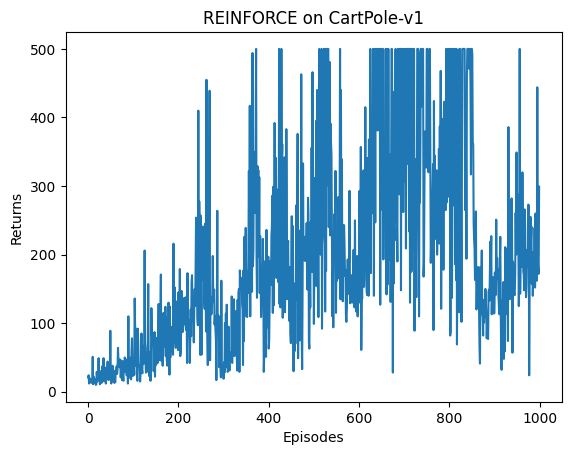

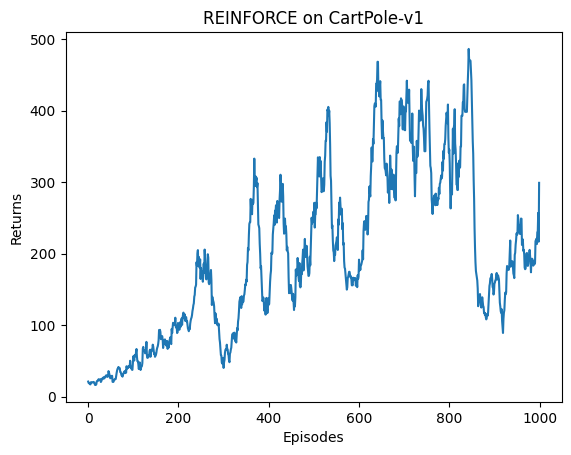

In [10]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('REINFORCE on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('REINFORCE on {}'.format(env_name))
plt.show()